<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto_Encoder


## 개념잡기
Auto Encoder란, 큰 데이터가 여러 layer를 거쳐 축소하였다가, 다시 복구하는 과정을 거쳐 데이터를 효율적으로 표현하는 방법이다.

기본적인 구조는 다음과 같다.


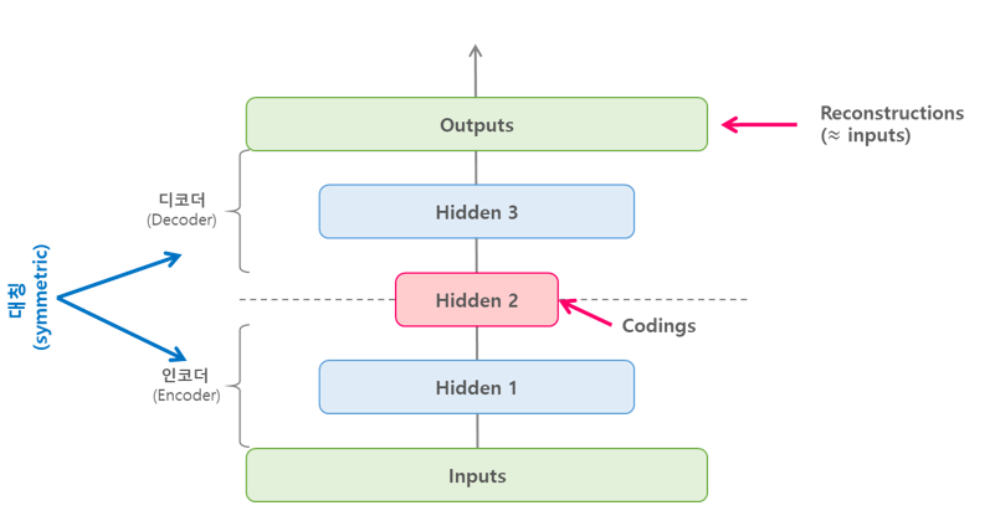

인코더 과정을 통해 데이터를 축소, 주요 특성 벡터만 남기고 이를 복구하는 과정을 통하여 데이터를 '잘' 표현하는  것이다.

## Auto_Encoder Example

실습은 다음 블로그를 바탕으로 진행한다.  
http://www.gisdeveloper.co.kr/?p=8900

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader

예제는 Fashion MNIST로 진행한다.

In [14]:
batch_size = 1024
root = './MNIST_Fashion'
transform = transforms.Compose([transforms.ToTensor()])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)


Extracting ./MNIST_Fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw




Extracting ./MNIST_Fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw




Extracting ./MNIST_Fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw




Extracting ./MNIST_Fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_Fashion/FashionMNIST/raw



Auto_Encoder에, CNN을 활용하여 이미지를 분류해보고자 한다.


In [15]:
z_size = 200
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            # 28 * 28 * 1 -> 14 * 14 * 32
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            # 14 * 14 * 32 -> 7 * 7 * 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            # 7 * 7 * 64 -> 3136
            Reshape((-1,7*7*64)),
            # 3136 -> 200
            nn.Linear(7*7*64, z_size),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            # 200 -> 3136
            nn.Linear(z_size, 7*7*64),
            nn.LeakyReLU(),
            # 3136 -> 7 * 7 * 64
            Reshape((-1,64,7,7)),
            # 7 * 7 * 64 -> 14 * 14 * 32
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, bias=False),
            nn.LeakyReLU(),
            # 14 * 14 * 32 -> 28 * 28 * 1
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

위에서 Reshape는 텐서의 크기를 변형해주는 것으로 이는 다음과 같이 사용된다.

In [16]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

학습 결과를 확인해보면 다음과 같다.

In [17]:
num_epochs = 15
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min')    
for i in range(num_epochs):
    for _, [image, _] in enumerate(train_loader):
        x = image.to(device)
        y_= image.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
 
    scheduler.step(loss)      
    print('Epoch: {}, Loss: {}, LR: {}'.format(i, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 0, Loss: 0.04289799928665161, LR: 0.001
Epoch: 1, Loss: 0.02242140658199787, LR: 0.001
Epoch: 2, Loss: 0.016558602452278137, LR: 0.001
Epoch: 3, Loss: 0.014638549648225307, LR: 0.001
Epoch: 4, Loss: 0.013551536947488785, LR: 0.001
Epoch: 5, Loss: 0.01199363823980093, LR: 0.001
Epoch: 6, Loss: 0.011292779818177223, LR: 0.001
Epoch: 7, Loss: 0.010612430982291698, LR: 0.001
Epoch: 8, Loss: 0.009382378309965134, LR: 0.001
Epoch: 9, Loss: 0.00942946132272482, LR: 0.001
Epoch: 10, Loss: 0.008690737187862396, LR: 0.0001
Epoch: 11, Loss: 0.008531913161277771, LR: 0.0001
Epoch: 12, Loss: 0.00851092766970396, LR: 1e-05
Epoch: 13, Loss: 0.008340747095644474, LR: 1e-05
Epoch: 14, Loss: 0.00836231280118227, LR: 1e-05
